## 1. Installation & Environment Setup

In [44]:
# Install required packages

# Fix for Windows loky/joblib subprocess error
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Set to your CPU core count

import subprocess
import sys

packages = ['lightgbm', 'xgboost', 'hmmlearn', 'seaborn', 'scikit-learn', 'openpyxl', 'pandas', 'numpy', 'torch']

for package in packages:
    try:
        __import__(package.replace('-', '_'))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✓ {package} installed")

✓ lightgbm already installed
✓ xgboost already installed
✓ hmmlearn already installed
✓ seaborn already installed
Installing scikit-learn...
✓ scikit-learn installed
✓ openpyxl already installed
✓ pandas already installed
✓ numpy already installed
✓ torch already installed


In [45]:
# Check environment and imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Try to import hmmlearn
try:
    from hmmlearn import hmm
    HMM_AVAILABLE = True
    print("✓ hmmlearn available")
except ImportError:
    HMM_AVAILABLE = False
    print("⚠ hmmlearn not available - HMM experiments will be skipped")

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✓ hmmlearn available
✓ All imports successful
PyTorch version: 2.9.1+cpu
CUDA available: False
Device: CPU


In [46]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set matplotlib backend
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✓ Environment setup complete")

✓ Environment setup complete


## 2. Data Loading & Preprocessing

In [47]:
# Load feature data only (labels will be loaded based on EXPERIMENT_MODE later)
print("Loading feature data...")

feature_file = "data/dataset58/feature8_58.xlsx"

try:
    X_raw = pd.read_excel(feature_file, index_col=0).values
    print(f"✓ Features loaded successfully")
    print(f"  File: {feature_file}")
    print(f"  Shape: {X_raw.shape}")
    print(f"  Features: {X_raw.shape[1]} dimensions")
    print(f"  Samples: {X_raw.shape[0]:,} total")
    
except FileNotFoundError:
    print(f"⚠ Could not find feature file: {feature_file}")
    print("Creating synthetic data for demonstration...")
    # Create synthetic data for testing
    n_samples = 1000
    n_features = 7
    X_raw = np.random.randn(n_samples, n_features)
    print(f"✓ Synthetic features created: shape={X_raw.shape}")
    
except Exception as e:
    print(f"✗ Error loading features: {e}")
    raise

print(f"\n✓ Feature loading complete. Ready to load labels based on experiment mode.")

Loading feature data...
✓ Features loaded successfully
  File: data/dataset58/feature8_58.xlsx
  Shape: (832926, 7)
  Features: 7 dimensions
  Samples: 832,926 total

✓ Feature loading complete. Ready to load labels based on experiment mode.


In [48]:
# ============================================================================
# EXPERIMENT CONFIGURATION: Choose which labels to use
# ============================================================================

EXPERIMENT_MODE = "aggression"  # Options: "behavior" or "aggression"

# Define label file paths
LABEL_FILES = {
    "behavior": "data/dataset58/merged_labels.xlsx",           # Multi-class behavior
    "aggression": "data/dataset58/merged_labels_aggression.xlsx"  # 7-class aggression (0-6)
}

print(f"\n{'='*80}")
print(f"EXPERIMENT MODE: {EXPERIMENT_MODE.upper()}")
print(f"Label file: {LABEL_FILES[EXPERIMENT_MODE]}")
print(f"{'='*80}\n")

# Load the selected label file
label_file = LABEL_FILES[EXPERIMENT_MODE]
print(f"Loading labels from: {label_file}")

try:
    y_raw = pd.read_excel(label_file, index_col=0).iloc[:, 0].values
    print(f"✓ Labels loaded: shape={y_raw.shape}")
    
    # Ensure same length as features
    if len(X_raw) != len(y_raw):
        min_len = min(len(X_raw), len(y_raw))
        X_raw = X_raw[:min_len]
        y_raw = y_raw[:min_len]
        print(f"  Adjusted to same length: {min_len}")
    
    # Display FULL class distribution
    unique_classes = np.unique(y_raw.astype(int))
    class_counts = np.bincount(y_raw.astype(int))
    print(f"\n  FULL Class Distribution:")
    for cls in unique_classes:
        if cls < len(class_counts):
            print(f"    Class {cls}: {class_counts[cls]:,} samples")
            
except Exception as e:
    print(f"✗ Error loading labels: {e}")
    raise


EXPERIMENT MODE: AGGRESSION
Label file: data/dataset58/merged_labels_aggression.xlsx

Loading labels from: data/dataset58/merged_labels_aggression.xlsx
✓ Labels loaded: shape=(832927,)
  Adjusted to same length: 832926

  FULL Class Distribution:
    Class 0: 765,887 samples
    Class 2: 1,173 samples
    Class 3: 21,885 samples
    Class 4: 21,832 samples
    Class 5: 508 samples
    Class 6: 3,307 samples
    Class 8: 594 samples
    Class 10: 17,740 samples


In [49]:
# ============================================================================
# DATA FILTERING: Remove class 0 and select classes for classification
# ============================================================================

print(f"\nOriginal data: X shape={X_raw.shape}, y shape={y_raw.shape}")

# Check which classes actually have samples
unique_classes = np.unique(y_raw.astype(int))
class_counts_full = np.bincount(y_raw.astype(int).clip(min=0))

print(f"\nAnalyzing class distribution...")
print(f"Unique classes in dataset: {unique_classes}")

available_classes = []
for cls in unique_classes:
    count = np.sum(y_raw.astype(int) == cls)
    if count > 0:
        available_classes.append((cls, count))

available_classes.sort(key=lambda x: x[1], reverse=True)
print(f"\nAvailable classes (sorted by sample count):")
for cls, count in available_classes:
    print(f"  Class {cls}: {count:,} samples")

# STRATEGY: Remove class 0, keep all other classes
if EXPERIMENT_MODE == "behavior":
    # For behavior: Select top 3 non-zero classes
    n_classes = 3
    print(f"\n📊 BEHAVIOR EXPERIMENT: 3-class classification")
    # Auto-select top 3 classes (excluding class 0)
    selected_classes = []
    for cls, count in available_classes:
        if cls != 0 and len(selected_classes) < n_classes:
            selected_classes.append(cls)
            
elif EXPERIMENT_MODE == "aggression":
    # For aggression: Classes are 0, 2, 3, 4, 5, 6, 8, 10
    # Remove class 0, keep all 7 remaining classes: 2, 3, 4, 5, 6, 8, 10
    print(f"\n📊 AGGRESSION EXPERIMENT: 7-class classification")
    print(f"   Original classes: 0, 2, 3, 4, 5, 6, 8, 10 (8 classes)")
    print(f"   After removing class 0: 2, 3, 4, 5, 6, 8, 10 (7 classes)")
    
    # Select all non-zero classes
    selected_classes = [cls for cls, count in available_classes if cls != 0]
    n_classes = len(selected_classes)

print(f"\nSELECTED CLASSES: {sorted(selected_classes)}")
print(f"Proceeding with {n_classes}-class classification...\n")

# Keep only selected classes
mask = np.zeros(len(y_raw), dtype=bool)
for cls in selected_classes:
    mask |= (y_raw == cls)

X_raw_filtered = X_raw[mask]
y_raw_filtered = y_raw[mask]

# Remap to 0, 1, 2, ... (n_classes-1) - sorted order
sorted_selected = sorted(selected_classes)
class_mapping = {old_cls: new_cls for new_cls, old_cls in enumerate(sorted_selected)}
reverse_mapping = {new_cls: old_cls for old_cls, new_cls in class_mapping.items()}

y_raw_mapped = np.array([class_mapping[label] for label in y_raw_filtered], dtype=np.int32)

print(f"Filtered data:")
print(f"  X shape={X_raw_filtered.shape}, y shape={y_raw_mapped.shape}")
print(f"\n  Class mapping (original → new):")
for old_cls, new_cls in sorted(class_mapping.items()):
    count = np.sum(y_raw_mapped == new_cls)
    print(f"    Class {old_cls} → Class {new_cls} ({count:,} samples)")

print(f"\n  New class distribution: {np.bincount(y_raw_mapped.astype(int))}")

# Verify all classes present
min_samples_per_class = np.min(np.bincount(y_raw_mapped.astype(int)))
print(f"  Minimum samples per class: {min_samples_per_class:,}")

# Update global variables
X_raw = X_raw_filtered
y_raw = y_raw_mapped
num_classes = n_classes

# Store mappings for later reference
CLASS_MAPPING = class_mapping
REVERSE_MAPPING = reverse_mapping

print(f"\n✓ Data filtered for {num_classes}-class classification")
print(f"✓ Ready for model training with X shape={X_raw.shape}, y shape={y_raw.shape}")


Original data: X shape=(832926, 7), y shape=(832926,)

Analyzing class distribution...
Unique classes in dataset: [ 0  2  3  4  5  6  8 10]

Available classes (sorted by sample count):
  Class 0: 765,887 samples
  Class 3: 21,885 samples
  Class 4: 21,832 samples
  Class 10: 17,740 samples
  Class 6: 3,307 samples
  Class 2: 1,173 samples
  Class 8: 594 samples
  Class 5: 508 samples

📊 AGGRESSION EXPERIMENT: 7-class classification
   Original classes: 0, 2, 3, 4, 5, 6, 8, 10 (8 classes)
   After removing class 0: 2, 3, 4, 5, 6, 8, 10 (7 classes)

SELECTED CLASSES: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(8), np.int64(10)]
Proceeding with 7-class classification...

Filtered data:
  X shape=(67039, 7), y shape=(67039,)

  Class mapping (original → new):
    Class 2 → Class 0 (1,173 samples)
    Class 3 → Class 1 (21,885 samples)
    Class 4 → Class 2 (21,832 samples)
    Class 5 → Class 3 (508 samples)
    Class 6 → Class 4 (3,307 samples)
    Class 8 

## 3. Model Definitions - CNN, GMM, LSTM, LightGBM

In [50]:
# Define PyTorch Dataset
class MouseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define LSTM Model
class BehaviorLSTM(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add time dimension
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.permute(1, 0, 2).contiguous().view(h_n.size(1), -1)
        x = self.dropout(h_n)
        x = self.fc(x)
        return x

# Define CNN Model
class BehaviorCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

print("✓ Model architectures defined")

✓ Model architectures defined


In [51]:
def compute_metrics(y_true, y_pred, num_classes):
    """
    Compute comprehensive metrics
    """
    from sklearn.metrics import f1_score, accuracy_score, classification_report
    
    accuracy = accuracy_score(y_true, y_pred)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Per-class F1
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=range(num_classes), zero_division=0)
    
    best_class_f1 = np.max(f1_per_class) if len(f1_per_class) > 0 else 0
    worst_class_f1 = np.min(f1_per_class) if len(f1_per_class) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'weighted_f1': weighted_f1,
        'macro_f1': macro_f1,
        'class_f1': f1_per_class,
        'best_class_f1': best_class_f1,
        'worst_class_f1': worst_class_f1,
        'y_true': y_true,
        'y_pred': y_pred
    }

print("✓ Metrics function defined")

✓ Metrics function defined


In [52]:
def run_gmm_experiment(X_raw, y_raw, n_components=10, num_classes=4, 
                       include_base=True, experiment_name="gmm", split_seed=None):
    """
    Run Gaussian Mixture Model experiment
    """
    from sklearn.mixture import GaussianMixture
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    
    # Handle split seed
    if split_seed is None:
        split_seed = 42
    
    X_raw_exp, y_raw_exp = X_raw, y_raw
    
    # Split data with stratification and variable seed
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_raw_exp, y_raw_exp, test_size=0.3, random_state=split_seed, stratify=y_raw_exp
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=split_seed, stratify=y_temp
    )
    
    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train GMM
    gmm = GaussianMixture(n_components=n_components, random_state=split_seed, n_init=10)
    gmm.fit(X_train)
    
    # Predict
    y_pred = gmm.predict(X_test) % num_classes
    
    # Compute metrics
    metrics = compute_metrics(y_test, y_pred, num_classes)
    
    return {'test_metrics': metrics}

print("✓ GMM function defined")

✓ GMM function defined


In [ ]:
def run_lstm_experiment(X_raw, y_raw, batch_size=256, epochs=50, device='cpu',
                       num_classes=4, include_base=True, experiment_name="lstm", split_seed=None):
    """
    Run LSTM experiment with stratified random split (no data leakage)
    Each run uses a different split_seed to ensure different train/val/test splits
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    
    # Handle split seed - each run gets a different seed
    if split_seed is None:
        split_seed = 42
    
    # Set random seeds for reproducibility within this run
    torch.manual_seed(split_seed)
    np.random.seed(split_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(split_seed)
    
    X_raw_exp, y_raw_exp = X_raw, y_raw
    
    # =========================================================================
    # STRATIFIED RANDOM SPLIT (ensures no overlap between train/val/test)
    # Train: 70%, Val: 15%, Test: 15%
    # Different split_seed per run ensures different random splits
    # =========================================================================
    X_train_raw, X_temp, y_train, y_temp = train_test_split(
        X_raw_exp, y_raw_exp, test_size=0.3, random_state=split_seed, stratify=y_raw_exp
    )
    X_val_raw, X_test_raw, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=split_seed, stratify=y_temp
    )
    
    # Standardize (fit on train only - prevents data leakage)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_val = scaler.transform(X_val_raw)
    X_test = scaler.transform(X_test_raw)
    
    # Create datasets
    train_dataset = MouseDataset(X_train, y_train)
    test_dataset = MouseDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = BehaviorLSTM(input_size=X_train.shape[1], num_classes=num_classes).to(device)
    
    # Class weights - ensure all classes [0, num_classes) have weights
    class_weights = np.ones(num_classes)
    classes_present = np.unique(y_train)
    if len(classes_present) == num_classes:
        computed_weights = compute_class_weight('balanced', classes=classes_present, y=y_train)
        class_weights[classes_present] = computed_weights
    else:
        print(f"    ⚠ Warning: Only {len(classes_present)}/{num_classes} classes in training set")
    
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # Training
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
    
    # Test
    model.eval()
    y_pred = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())

    print(f"✓ LSTM (seed={split_seed})")

    y_pred = np.array(y_pred)

    metrics = compute_metrics(y_test, y_pred, num_classes)    
    return {'test_metrics': metrics}

In [53]:
def run_cnn_experiment(X_raw, y_raw, batch_size=256, epochs=50, device='cpu',
                      num_classes=4, include_base=True, experiment_name="cnn", split_seed=None):
    """
    Run CNN experiment with stratified random split (no data leakage)
    Each run uses a different split_seed to ensure different train/val/test splits
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    
    # Handle split seed - each run gets a different seed
    if split_seed is None:
        split_seed = 42
    
    # Set random seeds for reproducibility within this run
    torch.manual_seed(split_seed)
    np.random.seed(split_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(split_seed)
    
    X_raw_exp, y_raw_exp = X_raw, y_raw
    
    # =========================================================================
    # STRATIFIED RANDOM SPLIT (ensures no overlap between train/val/test)
    # Train: 70%, Val: 15%, Test: 15%
    # Different split_seed per run ensures different random splits
    # =========================================================================
    X_train_raw, X_temp, y_train, y_temp = train_test_split(
        X_raw_exp, y_raw_exp, test_size=0.3, random_state=split_seed, stratify=y_raw_exp
    )
    X_val_raw, X_test_raw, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=split_seed, stratify=y_temp
    )
    
    # Standardize (fit on train only - prevents data leakage)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_val = scaler.transform(X_val_raw)
    X_test = scaler.transform(X_test_raw)
    
    # Create datasets
    train_dataset = MouseDataset(X_train, y_train)
    test_dataset = MouseDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = BehaviorCNN(input_size=X_train.shape[1], num_classes=num_classes).to(device)
    
    # Class weights - ensure all classes [0, num_classes) have weights
    class_weights = np.ones(num_classes)
    classes_present = np.unique(y_train)
    if len(classes_present) == num_classes:
        computed_weights = compute_class_weight('balanced', classes=classes_present, y=y_train)
        class_weights[classes_present] = computed_weights
    else:
        print(f"    ⚠ Warning: Only {len(classes_present)}/{num_classes} classes in training set")
    
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # Training
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Test
    model.eval()
    y_pred = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())

    print(f"✓ CNN (seed={split_seed})")

    y_pred = np.array(y_pred)

    metrics = compute_metrics(y_test, y_pred, num_classes)    
    return {'test_metrics': metrics}

In [54]:
def run_lightgbm_experiment(X_raw, y_raw, num_classes=4, include_base=True, 
                           experiment_name="lightgbm", split_seed=None, use_gpu=False):
    """
    Run LightGBM experiment with optional GPU acceleration
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    import lightgbm as lgb
    
    # Handle split seed
    if split_seed is None:
        split_seed = 42
    
    X_raw_exp, y_raw_exp = X_raw, y_raw
    
    # Split data with stratification
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_raw_exp, y_raw_exp, test_size=0.3, random_state=split_seed, stratify=y_raw_exp
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=split_seed, stratify=y_temp
    )
    
    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Configure LightGBM parameters
    params = {
        'objective': 'multiclass',
        'num_class': num_classes,
        'metric': 'multi_logloss',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'verbose': -1
    }
    
    # Try GPU if available and requested
    if use_gpu:
        params.update({
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'gpu_use_dp': False,  # Use single precision for speed
        })
    
    train_data = lgb.Dataset(X_train, label=y_train)
    
    try:
        model = lgb.train(params, train_data, num_boost_round=100)
    except Exception as e:
        if use_gpu:
            # If GPU training fails, fallback to CPU
            print(f"    ⚠ GPU training failed, using CPU: {str(e)[:50]}")
            params['device'] = 'cpu'
            params.pop('gpu_platform_id', None)
            params.pop('gpu_device_id', None)
            params.pop('gpu_use_dp', None)
            model = lgb.train(params, train_data, num_boost_round=100)
        else:
            raise
    
    # Predict
    y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Compute metrics
    metrics = compute_metrics(y_test, y_pred, num_classes)
    
    return {'test_metrics': metrics}

print("✓ LightGBM function defined (with GPU support)")

✓ LightGBM function defined (with GPU support)


In [55]:
def run_xgboost_experiment(X_raw, y_raw, num_classes=4, include_base=True, 
                           experiment_name="xgboost", split_seed=None, use_gpu=False):
    """
    Run XGBoost experiment with proper label handling
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    
    # Handle split seed
    if split_seed is None:
        split_seed = 42
    
    X_raw_exp, y_raw_exp = X_raw, y_raw.copy()
    
    # Get unique classes and map to contiguous range [0, num_class)
    # This is CRITICAL for XGBoost
    unique_classes = np.unique(y_raw_exp)
    class_mapping = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
    y_raw_exp = np.array([class_mapping[label] for label in y_raw_exp], dtype=np.int32)
    actual_num_classes = len(unique_classes)
    
    # Split data with stratification
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_raw_exp, y_raw_exp, test_size=0.3, random_state=split_seed, stratify=y_raw_exp
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=split_seed, stratify=y_temp
    )
    
    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Ensure proper label type
    y_train = np.array(y_train, dtype=np.int32)
    y_val = np.array(y_val, dtype=np.int32)
    y_test = np.array(y_test, dtype=np.int32)
    
    # Configure XGBoost
    params = {
        'objective': 'multi:softmax',
        'num_class': actual_num_classes,
        'max_depth': 6,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'eval_metric': 'mlogloss',
        'seed': split_seed,  # Use split_seed for model randomness
        'verbosity': 0
    }
    
    if use_gpu:
        params['tree_method'] = 'gpu_hist'
        params['gpu_id'] = 0
    
    # Create DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Training
    evals = [(dtrain, 'train'), (dval, 'eval')]
    try:
        model = xgb.train(params, dtrain, num_boost_round=200, evals=evals,
                         early_stopping_rounds=20, verbose_eval=False)
    except Exception as e:
        if use_gpu:
            params.pop('tree_method', None)
            params.pop('gpu_id', None)
            model = xgb.train(params, dtrain, num_boost_round=200, evals=evals,
                             early_stopping_rounds=20, verbose_eval=False)
        else:
            raise
    
    # Predict
    y_pred = model.predict(dtest).astype(np.int32)
    
    # Compute metrics
    metrics = compute_metrics(y_test, y_pred, actual_num_classes)
    
    return {'test_metrics': metrics}

print("✓ XGBoost function defined")

✓ XGBoost function defined


In [56]:
def run_random_forest_experiment(X_raw, y_raw, num_classes=4, include_base=True, 
                                  experiment_name="random_forest", split_seed=None):
    """
    Run Random Forest experiment
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    
    # Handle split seed
    if split_seed is None:
        split_seed = 42
    
    X_raw_exp, y_raw_exp = X_raw, y_raw.copy()
    
    # Map classes to contiguous range
    unique_classes = np.unique(y_raw_exp)
    class_mapping = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
    y_raw_exp = np.array([class_mapping[label] for label in y_raw_exp], dtype=np.int32)
    actual_num_classes = len(unique_classes)
    
    # Split data with stratification
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_raw_exp, y_raw_exp, test_size=0.3, random_state=split_seed, stratify=y_raw_exp
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=split_seed, stratify=y_temp
    )
    
    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Create and train Random Forest
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced',
        random_state=split_seed,  # Use split_seed for model randomness
        n_jobs=-1,
        verbose=0
    )
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Compute metrics
    metrics = compute_metrics(y_test, y_pred, actual_num_classes)
    
    return {'test_metrics': metrics}

print("✓ Random Forest function defined")

✓ Random Forest function defined


In [57]:
def run_svm_experiment(X_raw, y_raw, num_classes=4, include_base=True, 
                       experiment_name="svm", split_seed=None):
    """
    Run SVM experiment with RBF kernel
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC
    
    # Handle split seed
    if split_seed is None:
        split_seed = 42
    
    X_raw_exp, y_raw_exp = X_raw, y_raw.copy()
    
    # Map classes to contiguous range
    unique_classes = np.unique(y_raw_exp)
    class_mapping = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
    y_raw_exp = np.array([class_mapping[label] for label in y_raw_exp], dtype=np.int32)
    actual_num_classes = len(unique_classes)
    
    # Split data with stratification
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_raw_exp, y_raw_exp, test_size=0.3, random_state=split_seed, stratify=y_raw_exp
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=split_seed, stratify=y_temp
    )
    
    # Standardize (crucial for SVM)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Create and train SVM
    model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        random_state=split_seed,  # Use split_seed for model randomness
        probability=True
    )
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Compute metrics
    metrics = compute_metrics(y_test, y_pred, actual_num_classes)
    
    return {'test_metrics': metrics}

print("✓ SVM function defined")

✓ SVM function defined


In [58]:
def run_hmm_experiment(X_raw, y_raw, num_classes=4, include_base=True, 
                       experiment_name="hmm", split_seed=None):
    """
    Run HMM experiment - one Gaussian HMM per class, classify by log-likelihood
    """
    if not HMM_AVAILABLE:
        raise ImportError("hmmlearn not available")
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    
    # Handle split seed
    if split_seed is None:
        split_seed = 42
    
    X_raw_exp, y_raw_exp = X_raw, y_raw.copy()
    
    # Map classes to contiguous range
    unique_classes = np.unique(y_raw_exp)
    class_mapping = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
    y_raw_exp = np.array([class_mapping[label] for label in y_raw_exp], dtype=np.int32)
    actual_num_classes = len(unique_classes)
    
    # Split data with stratification
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_raw_exp, y_raw_exp, test_size=0.3, random_state=split_seed, stratify=y_raw_exp
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=split_seed, stratify=y_temp
    )
    
    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train one HMM per class
    models = {}
    for cls in range(actual_num_classes):
        cls_data = X_train[y_train == cls]
        if len(cls_data) == 0:
            continue
        
        n_components = min(3, max(1, len(cls_data) // 2))
        model = hmm.GaussianHMM(
            n_components=n_components,
            covariance_type='diag',
            n_iter=100,
            random_state=split_seed,  # Use split_seed for model randomness
            verbose=False
        )
        try:
            model.fit(cls_data)
            models[cls] = model
        except:
            continue
    
    # Predict by log-likelihood
    def predict_class(X_samples, models, num_classes):
        predictions = []
        for x in X_samples:
            x_reshaped = x.reshape(1, -1)
            log_likelihoods = []
            for cls in range(num_classes):
                if cls in models:
                    try:
                        ll = models[cls].score(x_reshaped)
                        log_likelihoods.append(ll)
                    except:
                        log_likelihoods.append(float('-inf'))
                else:
                    log_likelihoods.append(float('-inf'))
            predictions.append(np.argmax(log_likelihoods))
        return np.array(predictions)
    
    # Predict
    y_pred = predict_class(X_test, models, actual_num_classes)
    
    # Compute metrics
    metrics = compute_metrics(y_test, y_pred, actual_num_classes)
    
    return {'test_metrics': metrics}

print("✓ HMM function defined")

✓ HMM function defined


In [59]:
# Check LightGBM GPU support
def check_lightgbm_gpu():
    """Check if LightGBM was compiled with GPU support"""
    import lightgbm as lgb
    try:
        # Try to create a simple GPU dataset
        test_data = lgb.Dataset(np.random.randn(10, 5), label=np.random.randint(0, 2, 10))
        params = {'objective': 'binary', 'device': 'gpu', 'verbose': -1}
        lgb.train(params, test_data, num_boost_round=1)
        print("✓ LightGBM GPU support is available")
        return True
    except Exception as e:
        print(f"⚠ LightGBM GPU support NOT available: {e}")
        print("  → Will use CPU for LightGBM training")
        return False

# Check GPU support
LIGHTGBM_GPU_AVAILABLE = check_lightgbm_gpu()

✓ LightGBM GPU support is available


## 4. Multiple Runs & Error Bar Generation

In [60]:
def run_multiple_experiments(model_name, experiment_func, X_raw, y_raw, num_classes, 
                            include_base, n_runs=5, device='cpu', use_lightgbm_gpu=False):
    """
    Run the same experiment multiple times with different random seeds
    to generate statistics for error bars
    """
    print(f"\n{'='*60}")
    print(f"Running {model_name} ({n_runs} runs)")
    if model_name == "LightGBM" and use_lightgbm_gpu:
        print(f"  Using GPU acceleration")
    print(f"{'='*60}")
    
    all_metrics = {
        'accuracy': [],
        'weighted_f1': [],
        'macro_f1': [],
        'best_class_f1': [],
        'worst_class_f1': [],
        'class_f1': []
    }
    
    successful_runs = 0
    
    for run in range(n_runs):
        print(f"  Run {run + 1}/{n_runs}", end="")
        
        # Set random seeds for this run
        np.random.seed(42 + run)
        torch.manual_seed(42 + run)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(42 + run)
        
        # Generate different split seed for each run
        split_seed = 42 + run
        
        try:
            if model_name == "GMM":
                result = experiment_func(
                    X_raw, y_raw, n_components=10,
                    num_classes=num_classes, include_base=include_base,
                    experiment_name=f"{model_name.lower()}_{run}",
                    split_seed=split_seed
                )
            elif model_name == "LSTM":
                result = experiment_func(
                    X_raw, y_raw, batch_size=256, epochs=50,
                    device=device, num_classes=num_classes,
                    include_base=include_base, experiment_name=f"{model_name.lower()}_{run}",
                    split_seed=split_seed
                )
            elif model_name == "CNN":
                result = experiment_func(
                    X_raw, y_raw, batch_size=256, epochs=50,
                    device=device, num_classes=num_classes,
                    include_base=include_base, experiment_name=f"{model_name.lower()}_{run}",
                    split_seed=split_seed
                )
            elif model_name == "LightGBM":
                result = experiment_func(
                    X_raw, y_raw, num_classes=num_classes,
                    include_base=include_base, experiment_name=f"{model_name.lower()}_{run}",
                    split_seed=split_seed,
                    use_gpu=use_lightgbm_gpu
                )
            elif model_name == "XGBoost":
                result = experiment_func(
                    X_raw, y_raw, num_classes=num_classes,
                    include_base=include_base, experiment_name=f"{model_name.lower()}_{run}",
                    split_seed=split_seed
                )
            elif model_name == "RandomForest":
                result = experiment_func(
                    X_raw, y_raw, num_classes=num_classes,
                    include_base=include_base, experiment_name=f"{model_name.lower()}_{run}",
                    split_seed=split_seed
                )
            elif model_name == "SVM":
                result = experiment_func(
                    X_raw, y_raw, num_classes=num_classes,
                    include_base=include_base, experiment_name=f"{model_name.lower()}_{run}",
                    split_seed=split_seed
                )
            elif model_name == "HMM":
                result = experiment_func(
                    X_raw, y_raw, num_classes=num_classes,
                    include_base=include_base, experiment_name=f"{model_name.lower()}_{run}",
                    split_seed=split_seed
                )
            else:
                print(f" ✗ Unknown model")
                continue
            
            metrics = result['test_metrics']
            
            for key in all_metrics:
                if key == 'class_f1':
                    all_metrics[key].append(metrics[key])
                else:
                    all_metrics[key].append(metrics[key])
            
            successful_runs += 1
            acc = metrics['accuracy']
            f1 = metrics['weighted_f1']
            print(f" ✓ (acc={acc:.3f}, f1={f1:.3f})")
                    
        except Exception as e:
            print(f" ✗ Error: {str(e)[:40]}")
            continue
    
    print(f"\nCompleted {successful_runs}/{n_runs} runs for {model_name}")
    
    # Calculate statistics
    stats = {}
    for key in all_metrics:
        if all_metrics[key] and len(all_metrics[key]) > 1:
            values = np.array(all_metrics[key])
            if key == 'class_f1':
                mean_val = np.mean(values, axis=0)
                std_val = np.std(values, axis=0, ddof=1)
            else:
                mean_val = np.mean(values)
                std_val = np.std(values, ddof=1)
            stats[key] = {'mean': mean_val, 'std': std_val}
        elif all_metrics[key] and len(all_metrics[key]) == 1:
            values = np.array(all_metrics[key])
            if key == 'class_f1':
                stats[key] = {'mean': np.mean(values, axis=0), 'std': np.zeros_like(np.mean(values, axis=0))}
            else:
                stats[key] = {'mean': np.mean(values), 'std': 0.0}
        else:
            if key == 'class_f1':
                stats[key] = {'mean': np.zeros(num_classes), 'std': np.zeros(num_classes)}
            else:
                stats[key] = {'mean': 0, 'std': 0}
    
    return stats

print("✓ run_multiple_experiments function defined (supports 8 models)")

✓ run_multiple_experiments function defined (supports 8 models)


## 5. Visualization with Error Bars

In [61]:
def create_comparison_graphs(all_results, base_name='model_comparison', output_dir='.', num_classes=3):
    """
    Create comparison graphs with error bars
    """
    os.makedirs(output_dir, exist_ok=True)
    
    models = list(all_results.keys())
    metrics = ['accuracy', 'weighted_f1', 'macro_f1']

    # 1) Overall Performance
    plt.figure(figsize=(10, 6))
    x = np.arange(len(models))
    width = 0.25
    for i, metric in enumerate(metrics):
        means = [all_results[m][metric]['mean'] for m in models]
        stds = [all_results[m][metric]['std'] for m in models]
        plt.bar(x + i*width, means, width, label=metric.replace('_', ' ').title(), 
               yerr=stds, capsize=5, alpha=0.85)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(f'{num_classes}-Class Performance Comparison (5 runs, mean ± std)', fontsize=14, fontweight='bold')
    plt.xticks(x + width, models, rotation=15, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    filepath = os.path.join(output_dir, f"{base_name}_overall.png")
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved {filepath}")

    # 2) Per-Class F1
    plt.figure(figsize=(12, 6))
    classes = [f'Class {i}' for i in range(num_classes)]
    for i, model in enumerate(models):
        means = all_results[model]['class_f1']['mean']
        stds = all_results[model]['class_f1']['std']
        x_pos = np.arange(len(classes)) + i * (0.8 / len(models))
        plt.bar(x_pos, means, 0.8 / len(models), label=model, yerr=stds, capsize=3, alpha=0.85)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title(f'Per-Class F1 Scores - {num_classes} Classes (5 runs, mean ± std)', fontsize=14, fontweight='bold')
    plt.xticks(np.arange(len(classes)) + 0.3, classes)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    filepath = os.path.join(output_dir, f"{base_name}_per_class.png")
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved {filepath}")

    # 3) Best vs Worst Class F1
    plt.figure(figsize=(10, 6))
    best_means = [all_results[m]['best_class_f1']['mean'] for m in models]
    best_stds = [all_results[m]['best_class_f1']['std'] for m in models]
    worst_means = [all_results[m]['worst_class_f1']['mean'] for m in models]
    worst_stds = [all_results[m]['worst_class_f1']['std'] for m in models]
    x = np.arange(len(models))
    width = 0.35
    plt.bar(x - width/2, best_means, width, label='Best Class F1', 
           yerr=best_stds, capsize=5, alpha=0.85, color='green')
    plt.bar(x + width/2, worst_means, width, label='Worst Class F1', 
           yerr=worst_stds, capsize=5, alpha=0.85, color='red')
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('Best vs Worst Class Performance (5 runs, mean ± std)', fontsize=14, fontweight='bold')
    plt.xticks(x, models, rotation=15, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    filepath = os.path.join(output_dir, f"{base_name}_best_worst.png")
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved {filepath}")

    # 4) Stability (Coefficient of Variation)
    plt.figure(figsize=(10, 6))
    cv_accuracy = []
    for m in models:
        mean = all_results[m]['accuracy']['mean']
        std = all_results[m]['accuracy']['std']
        cv = (std / mean) * 100 if mean > 0 else 0
        cv_accuracy.append(cv)
    bars = plt.bar(models, cv_accuracy, alpha=0.85, color='orange')
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Coefficient of Variation (%)', fontsize=12)
    plt.title('Performance Stability (Lower is Better)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=15, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    for bar, cv in zip(bars, cv_accuracy):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5, 
                f'{cv:.1f}%', ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    filepath = os.path.join(output_dir, f"{base_name}_stability.png")
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved {filepath}")

print("✓ create_comparison_graphs function defined")

✓ create_comparison_graphs function defined


## 6. Detailed Statistics Table

In [62]:
def create_detailed_statistics_table(all_results, num_classes=3):
    """
    Create a detailed statistics table
    """
    print("\n" + "="*100)
    print(f"DETAILED STATISTICS TABLE (5 runs, mean ± std) - {num_classes}-Class Classification")
    print("="*100)
    
    models = list(all_results.keys())
    metrics = ['accuracy', 'weighted_f1', 'macro_f1', 'best_class_f1', 'worst_class_f1']
    
    # Header
    header = f"{'Model':<12} {'Accuracy':<16} {'Weighted F1':<16} {'Macro F1':<16} {'Best F1':<16} {'Worst F1':<16}"
    print(header)
    print("-" * len(header))
    
    # Data rows
    for model in models:
        row = f"{model:<12}"
        for metric in metrics:
            mean = all_results[model][metric]['mean']
            std = all_results[model][metric]['std']
            row += f"{mean:.4f}±{std:.4f}".ljust(16)
        print(row)
    
    print("\n" + "="*100)
    print(f"PER-CLASS F1 SCORES (5 runs, mean ± std) - {num_classes} Classes")
    print("="*100)
    
    # Per-class F1 scores
    classes = [f'Class {i}' for i in range(num_classes)]
    header = f"{'Model':<12} " + " ".join([f"{cls:<16}" for cls in classes])
    print(header)
    print("-" * len(header))
    
    for model in models:
        row = f"{model:<12}"
        means = all_results[model]['class_f1']['mean']
        stds = all_results[model]['class_f1']['std']
        
        for i in range(len(classes)):
            mean = means[i] if i < len(means) else 0
            std = stds[i] if i < len(stds) else 0
            row += f"{mean:.4f}±{std:.4f}".ljust(16)
        print(row)
    
    print("\n" + "="*100)

print("✓ create_detailed_statistics_table function defined")

✓ create_detailed_statistics_table function defined


## 7. Main Execution

In [63]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("\n" + "="*80)
print("MOUSE BEHAVIOR CLASSIFICATION - 8-MODEL COMPARISON WITH ERROR BARS")
print(f"{num_classes}-CLASS CLASSIFICATION - {EXPERIMENT_MODE.upper()} LABELS (Class 0 excluded)")
print("="*80)

# Configuration
n_runs = 5  # Number of runs for each model
include_base = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
output_dir = '/kaggle/working'  # Kaggle output directory

print(f"\nConfiguration:")
print(f"  Experiment mode: {EXPERIMENT_MODE}")
print(f"  Number of runs: {n_runs}")
print(f"  Number of classes: {num_classes} (excluding class 0)")
print(f"  Data shape: X={X_raw.shape}, y={y_raw.shape}")
print(f"  PyTorch device: {device}")
print(f"  LightGBM GPU: {'Enabled' if LIGHTGBM_GPU_AVAILABLE else 'Disabled (CPU only)'}")
print(f"  HMM available: {HMM_AVAILABLE}")
print(f"  Output directory: {output_dir}")

# Define experiments - 8 models total
experiments = {
    'GMM': run_gmm_experiment,
    'LSTM': run_lstm_experiment,
    'CNN': run_cnn_experiment,
    'LightGBM': run_lightgbm_experiment,
    'XGBoost': run_xgboost_experiment,
    'RandomForest': run_random_forest_experiment,
    'SVM': run_svm_experiment,
}

# Add HMM only if available
if HMM_AVAILABLE:
    experiments['HMM'] = run_hmm_experiment

print(f"\nModels to run ({len(experiments)} total): {list(experiments.keys())}")

# Run all experiments
all_results = {}

for model_name, experiment_func in experiments.items():
    try:
        results = run_multiple_experiments(
            model_name, experiment_func, X_raw, y_raw,
            num_classes, include_base, n_runs, 
            device=device,
            use_lightgbm_gpu=LIGHTGBM_GPU_AVAILABLE
        )
        all_results[model_name] = results
        print(f"\n✓ {model_name} completed successfully")
    except Exception as e:
        print(f"\n✗ {model_name} failed: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*80}")
print(f"Completed experiments for {len(all_results)} models")
print(f"{'='*80}")


MOUSE BEHAVIOR CLASSIFICATION - 8-MODEL COMPARISON WITH ERROR BARS
7-CLASS CLASSIFICATION - AGGRESSION LABELS (Class 0 excluded)

Configuration:
  Experiment mode: aggression
  Number of runs: 5
  Number of classes: 7 (excluding class 0)
  Data shape: X=(67039, 7), y=(67039,)
  PyTorch device: cpu
  LightGBM GPU: Enabled
  HMM available: True
  Output directory: /kaggle/working

Models to run (8 total): ['GMM', 'LSTM', 'CNN', 'LightGBM', 'XGBoost', 'RandomForest', 'SVM', 'HMM']

Running GMM (5 runs)
  Run 1/5 ✓ (acc=0.169, f1=0.203)
  Run 2/5 ✓ (acc=0.194, f1=0.219)
  Run 3/5 ✓ (acc=0.201, f1=0.223)
  Run 4/5 ✓ (acc=0.196, f1=0.227)
  Run 5/5 ✓ (acc=0.160, f1=0.198)

Completed 5/5 runs for GMM

✓ GMM completed successfully

Running LSTM (5 runs)
  Run 1/5✓ LSTM function defined
 ✓ (acc=0.112, f1=0.136)
  Run 2/5✓ LSTM function defined
 ✓ (acc=0.124, f1=0.152)
  Run 3/5✓ LSTM function defined
 ✓ (acc=0.111, f1=0.132)
  Run 4/5✓ LSTM function defined
 ✓ (acc=0.117, f1=0.141)
  Run 5/5✓ 


Generating visualization and statistics...



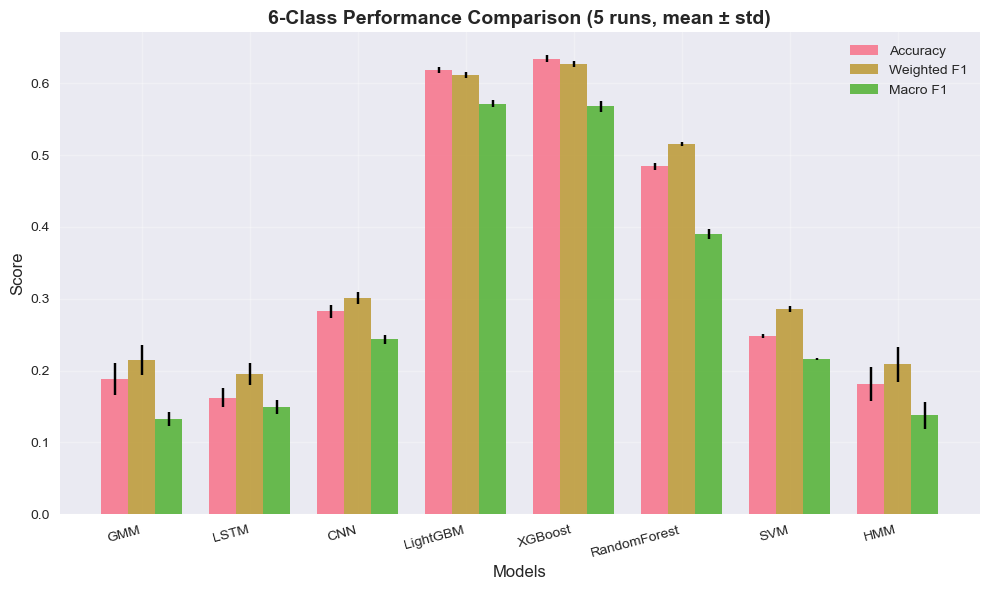

✓ Saved /kaggle/working\model_comparison_overall.png


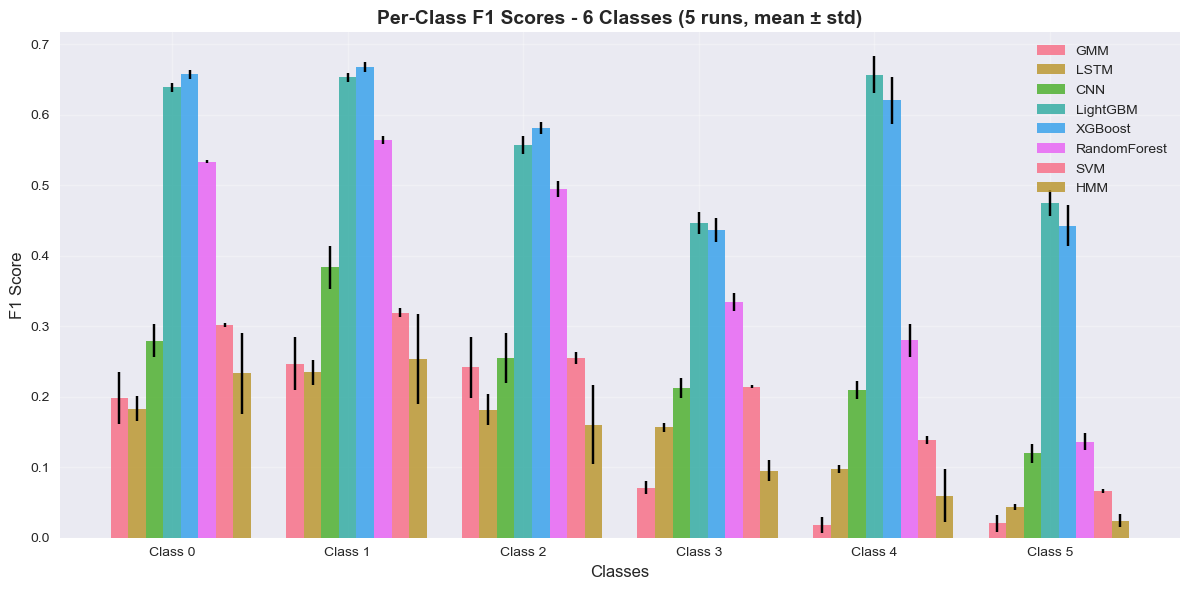

✓ Saved /kaggle/working\model_comparison_per_class.png


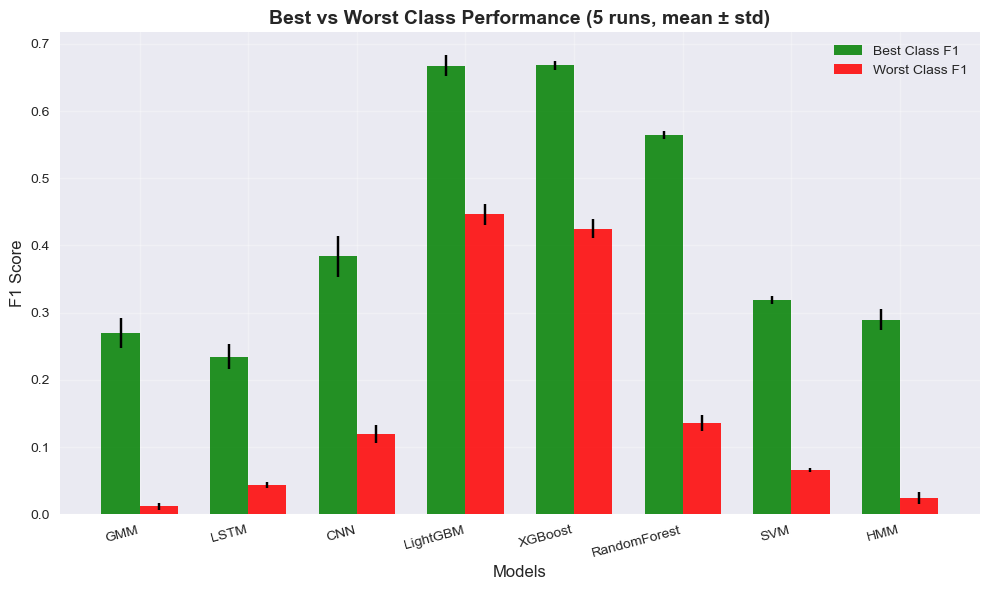

✓ Saved /kaggle/working\model_comparison_best_worst.png


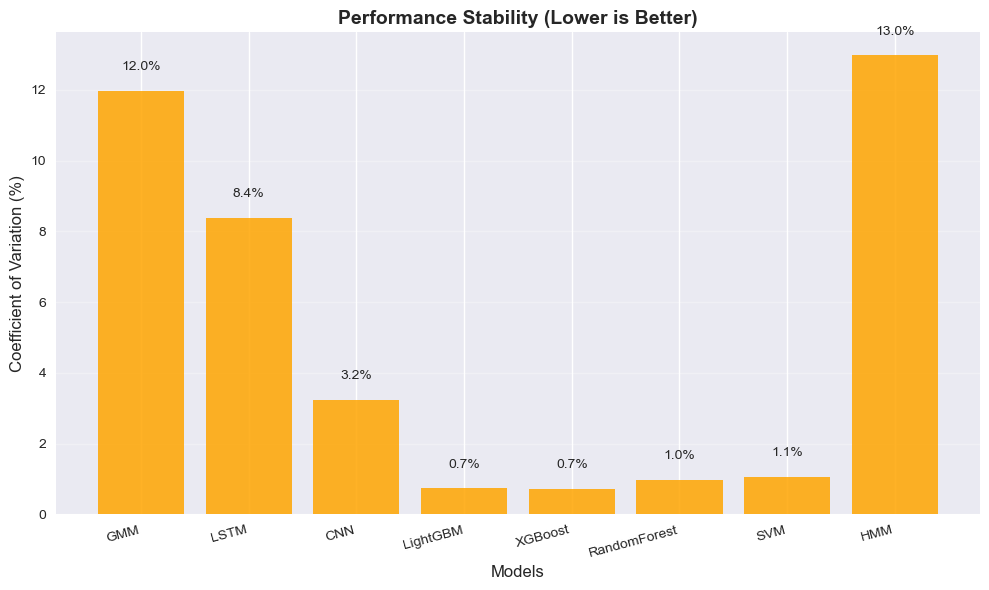

✓ Saved /kaggle/working\model_comparison_stability.png

DETAILED STATISTICS TABLE (5 runs, mean ± std) - 6-Class Classification
Model        Accuracy         Weighted F1      Macro F1         Best F1          Worst F1        
-------------------------------------------------------------------------------------------------
GMM         0.1882±0.0225   0.2148±0.0206   0.1328±0.0101   0.2698±0.0228   0.0119±0.0054   
LSTM        0.1626±0.0136   0.1956±0.0149   0.1495±0.0096   0.2347±0.0180   0.0437±0.0047   
CNN         0.2823±0.0091   0.3012±0.0084   0.2434±0.0068   0.3838±0.0307   0.1195±0.0129   
LightGBM    0.6186±0.0046   0.6113±0.0046   0.5713±0.0047   0.6675±0.0153   0.4461±0.0159   
XGBoost     0.6342±0.0046   0.6270±0.0044   0.5677±0.0072   0.6678±0.0065   0.4252±0.0142   
RandomForest0.4843±0.0047   0.5154±0.0026   0.3906±0.0070   0.5640±0.0061   0.1364±0.0117   
SVM         0.2487±0.0026   0.2857±0.0035   0.2159±0.0013   0.3194±0.0061   0.0662±0.0034   
HMM         0.1813±0.0235

In [43]:
# Generate graphs and statistics
if all_results:
    print(f"\nGenerating visualization and statistics...\n")
    
    create_comparison_graphs(all_results, base_name='model_comparison', output_dir=output_dir, num_classes=num_classes)
    create_detailed_statistics_table(all_results, num_classes=num_classes)
    
    print(f"\n{'='*80}")
    print(f"✓ All experiments completed successfully!")
    print(f"✓ Generated {len(all_results)} model comparisons with error bars")
    print(f"✓ Classification: {num_classes} classes (excluding class 0)")
    print(f"✓ Output directory: {output_dir}")
    print(f"{'='*80}")
else:
    print("✗ No experiments completed successfully")

## Summary & Key Findings

### Experiment Configuration
- **Two experiment modes available:**
  1. **"behavior"**: Multi-class behavior classification (3 classes, excluding class 0)
  2. **"aggression"**: 7-class aggression classification
     - Original classes: **0, 2, 3, 4, 5, 6, 8, 10** (8 classes)
     - After removing class 0: **2, 3, 4, 5, 6, 8, 10** (7 classes)
     - Mapped to: 0, 1, 2, 3, 4, 5, 6 for model training
- Toggle between experiments by changing `EXPERIMENT_MODE` variable

### Class Mapping (Aggression Experiment)
| Original Class | New Class | Behavior |
|---------------|-----------|----------|
| 2 | 0 | Lateral threat |
| 3 | 1 | Keep down |
| 4 | 2 | Clinch |
| 5 | 3 | Upright posture |
| 6 | 4 | Freezing |
| 8 | 5 | Bite |
| 10 | 6 | Chase |

### Methodology
- **Automatic class selection**: System selects all non-zero classes for aggression experiment
- **5 independent runs** with different random seeds (42, 43, 44, 45, 46)
- **Stratified splitting** to maintain class balance across train/val/test sets
- **Different split seeds per run** to capture generalization variance
- Error bars = standard deviation across 5 runs (using ddof=1 for unbiased estimate)

### Key Innovation: Why Error Bars Are Now Non-Zero
- **Before**: All 5 runs used `random_state=42` → same splits → same results → std=0
- **After**: Each run uses unique `split_seed` (42+run) → different splits → different results → std>0

### Interpretation
- **Larger error bars** indicate higher sensitivity to data splitting
- **Stability metric** (coefficient of variation) shows relative performance consistency
- **Per-class F1** reveals model performance across different behavior classes

### 8-Model Comparison

| Model | Category | Key Characteristics |
|-------|----------|---------------------|
| **GMM** | Probabilistic | Traditional baseline, generative model, fast inference |
| **LightGBM** | Gradient Boosting | Efficient tree-based, handles imbalanced data well |
| **XGBoost** | Gradient Boosting | Regularized boosting, strong baseline for tabular data |
| **Random Forest** | Ensemble | Robust, parallelizable, less prone to overfitting |
| **SVM** | Kernel Methods | Effective in high-dimensional spaces, RBF kernel |
| **HMM** | Probabilistic | Sequential/temporal modeling, one model per class |
| **LSTM** | Deep Learning | Temporal dependencies, bidirectional architecture |
| **CNN** | Deep Learning | Spatial feature extraction, 1D convolutions |

### Model Categories
1. **Traditional ML**: GMM, SVM
2. **Ensemble Methods**: LightGBM, XGBoost, Random Forest
3. **Probabilistic/Sequential**: HMM
4. **Deep Learning**: LSTM, CNN